In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
data = run('NQ', roc, output=True)

weights: 
roc_5      0.171951
roc_10     0.127956
roc_20     0.117145
roc_40     0.113007
roc_80     0.147857
roc_160    0.322084

adjustments:
roc_5      35.183903
roc_10     26.043514
roc_20     17.715115
roc_40     12.620106
roc_80     10.050039
roc_160     9.887718

multiplier:
1.4153580681238283

correlations:
            roc_5    roc_10    roc_20    roc_40    roc_80   roc_160
roc_5    1.000000  0.584550  0.299374  0.114489 -0.050989 -0.147726
roc_10   0.584550  1.000000  0.658236  0.346849  0.011121 -0.182264
roc_20   0.299374  0.658236  1.000000  0.657831  0.177702 -0.151445
roc_40   0.114489  0.346849  0.657831  1.000000  0.566070  0.053171
roc_80  -0.050989  0.011121  0.177702  0.566070  1.000000  0.389072
roc_160 -0.147726 -0.182264 -0.151445  0.053171  0.389072  1.000000

simulation start date: 2019-01-01 00:00:00


In [10]:
data.forecast.abs().mean(), data.forecast.abs().std()

(10.301478452223666, 5.585944720048132)

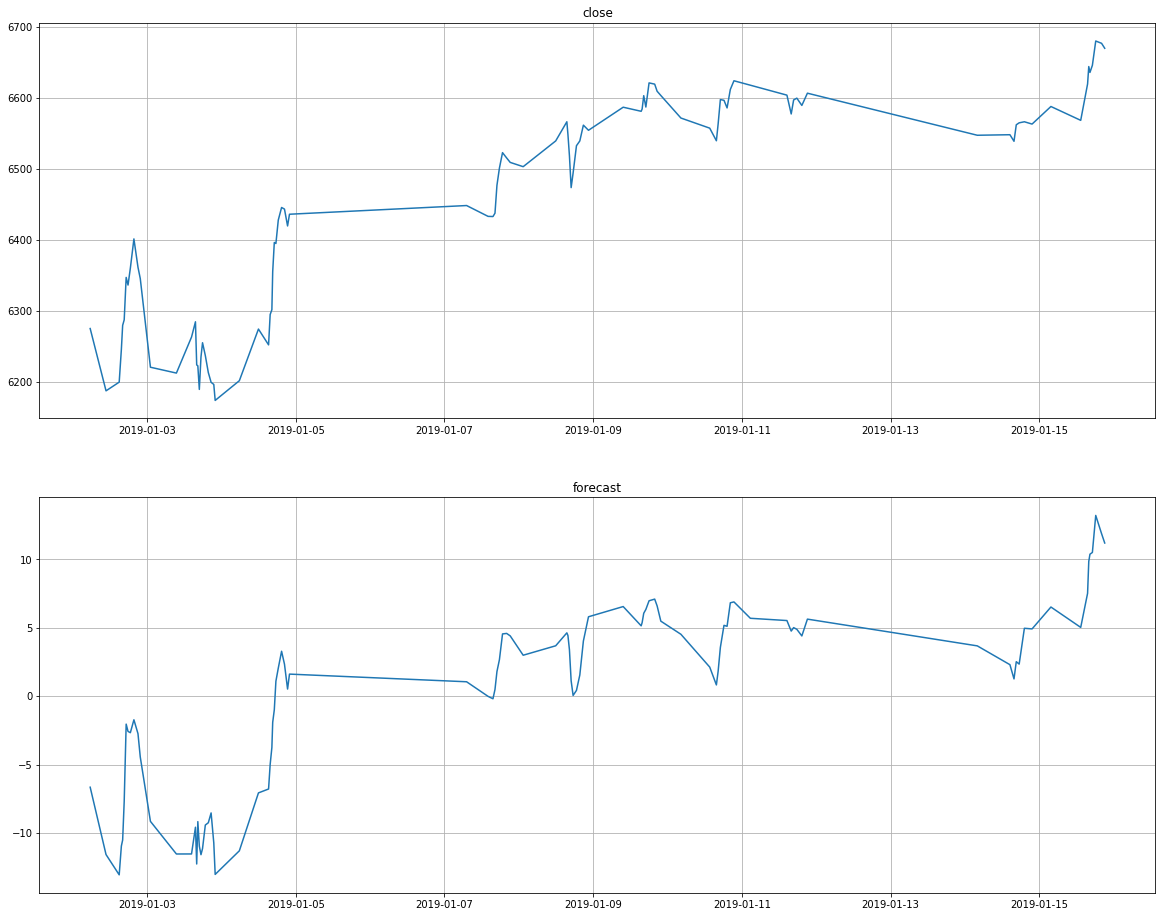

In [11]:
plot(data[['close', 'forecast']].iloc[:100])

In [12]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.108522,0.287465,0.214268,0.211506,0.0630863,-0.0132944,-0.11601,-0.14091,-0.0794564
Cumulative returns,0.0750473,0.194197,0.146096,0.144264,0.0439056,-0.00935629,-0.0829656,-0.101186,-0.0564923
Annual volatility,0.176616,0.159939,0.155064,0.147971,0.148362,0.139189,0.086206,0.0664771,0.0473739
Sharpe ratio,0.671303,1.65995,1.32941,1.37053,0.486221,-0.0267952,-1.38725,-2.25094,-1.7239
Calmar ratio,0.773383,4.58807,3.39599,4.19432,1.08996,-0.144049,-1.06982,-1.19776,-1.36006
Stability,0.641223,0.920395,0.858838,0.885957,0.629949,0.45383,0.869336,0.901007,0.856227
Max drawdown,-0.140321,-0.0626549,-0.0630944,-0.0504268,-0.0578794,-0.0922906,-0.108439,-0.117645,-0.0584211
Omega ratio,1.11899,1.32667,1.25879,1.28071,1.09078,0.994925,0.693928,0.441962,0.4297
Sortino ratio,0.964128,2.63633,2.06201,2.12483,0.688152,-0.0363226,-1.91165,-2.80933,-2.51031
Skew,-0.0880221,0.202345,0.25126,0.269132,-0.163472,-0.354523,0.501677,-0.145418,3.07739


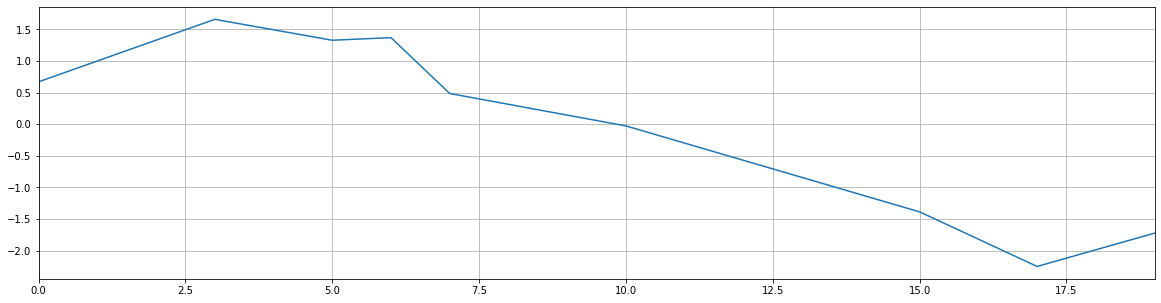

In [13]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [14]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.924924,0.867281,0.849547,0.807154,0.660084,0.358672,0.159063,0.145877
3,0.924924,1.000000,0.953687,0.923499,0.882718,0.738652,0.433560,0.222539,0.173022
5,0.867281,0.953687,1.000000,0.971809,0.932212,0.792087,0.470111,0.227635,0.178743
6,0.849547,0.923499,0.971809,1.000000,0.960296,0.813333,0.485396,0.222634,0.186810
7,0.807154,0.882718,0.932212,0.960296,1.000000,0.840242,0.494131,0.277652,0.223073
10,0.660084,0.738652,0.792087,0.813333,0.840242,1.000000,0.614162,0.348241,0.233466
15,0.358672,0.433560,0.470111,0.485396,0.494131,0.614162,1.000000,0.593711,0.433293
17,0.159063,0.222539,0.227635,0.222634,0.277652,0.348241,0.593711,1.000000,0.737214
19,0.145877,0.173022,0.178743,0.186810,0.223073,0.233466,0.433293,0.737214,1.000000


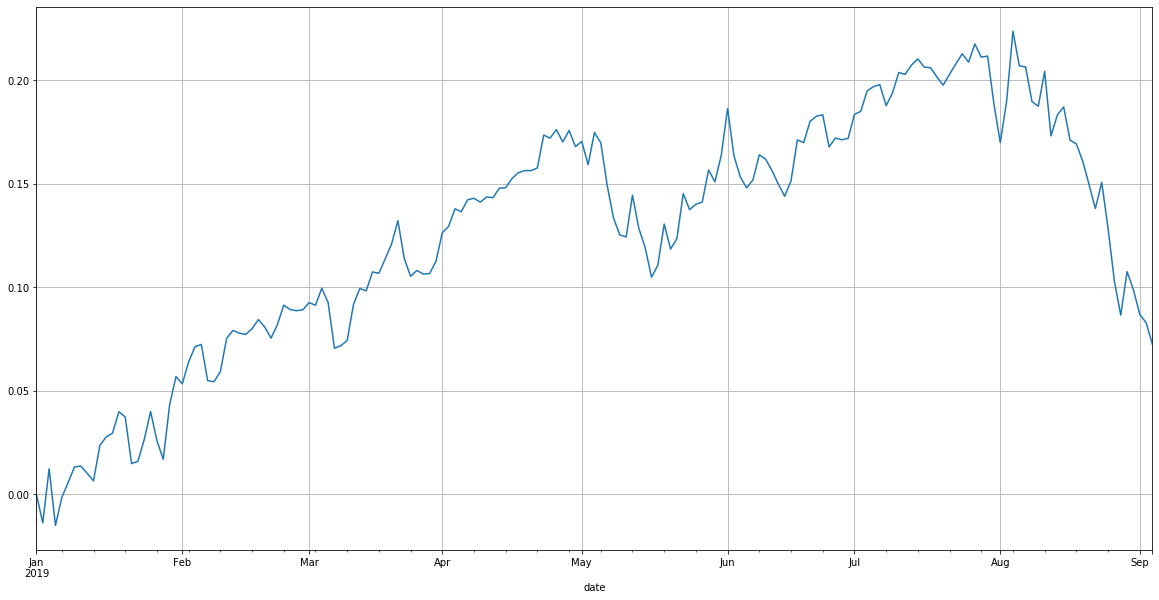

In [15]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

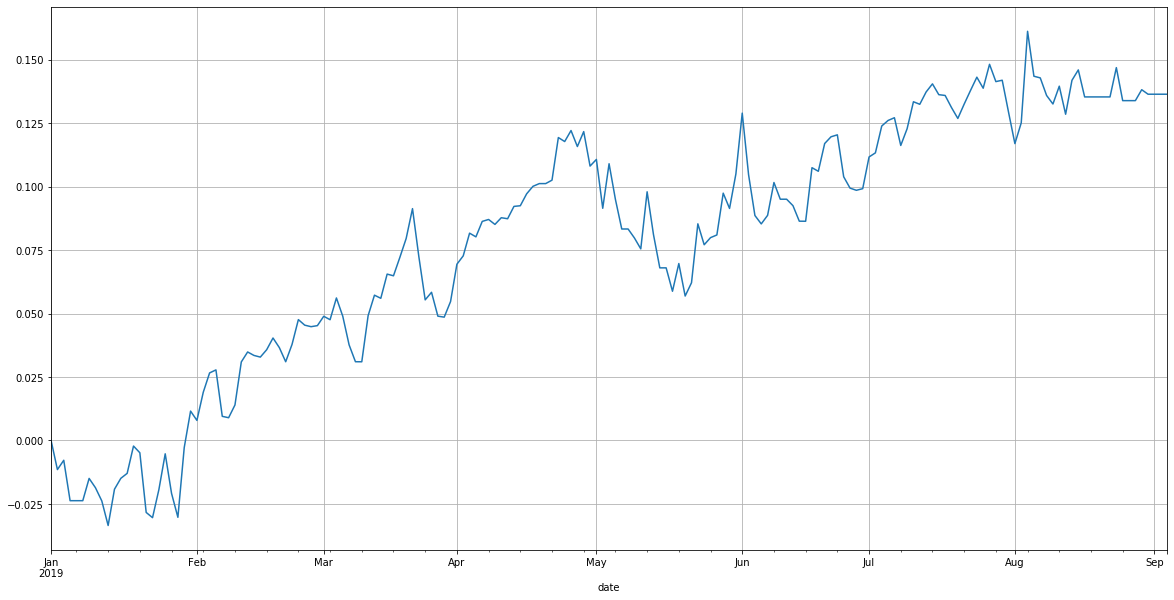

In [16]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

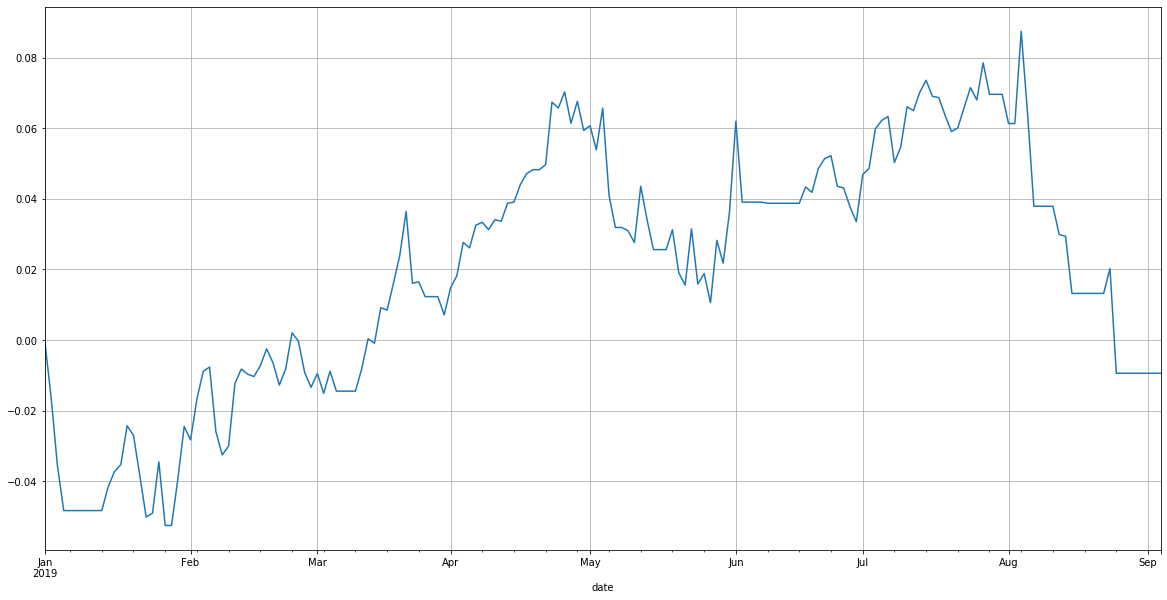

In [17]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);